# Stitching and Normalisation

In this notebook we look at how to stitch CMIP6 output files together to create continuous timeseries and how to determine how to normalise these files e.g. calculate anomalies against piControl runs.

In [1]:
# NBVAL_IGNORE_OUTPUT
import datetime as dt
import glob
import os.path
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import pymagicc
import seaborn as sns
import tqdm
from scmdata import run_append, ScmRun

from netcdf_scm.io import load_mag_file, load_scmrun
from netcdf_scm.normalisation import get_normaliser
from netcdf_scm.stitching import (
    get_branch_time,
    get_parent_file_path,
    get_parent_replacements,
    step_up_family_tree,
)

In [2]:
plt.style.use("bmh")
%matplotlib inline

## Command line interface help

The help can be accessed via our command line interface.

In [3]:
# NBVAL_IGNORE_OUTPUT
!netcdf-scm stitch -h

Usage: netcdf-scm stitch [OPTIONS] SRC DST STITCH_CONTACT

  Stitch netCDF-SCM ``.nc`` files together and write out in the specified
  format.

  ``SRC`` is searched recursively and netcdf-scm will attempt to stitch all
  the files found. Output is written in ``DST``.

  ``STITCH_CONTACT`` is written into the header of the output files.

Options:
  --regexp TEXT                   Regular expression to apply to file
                                  directory (only stitches matches). Be
                                  careful, if you use a very copmlex regexp
                                  directory sorting can be extremely slow (see
                                  e.g. discussion at
                                  https://stackoverflow.com/a/5428712)!
                                  [default: ^(?!.*(fx)).*$]

  --prefix TEXT                   Prefix to apply to output file names (not
                                  paths).

  --out-format [mag-files|mag-files-average-year-

## Stitching

Stitching simply refers to joining a child scenario with its parent. For example, an ssp with its corresponding historical run.

In [4]:
# NBVAL_IGNORE_OUTPUT
!netcdf-scm stitch \
    "../../../tests/test-data/expected-crunching-output/cmip6output" \
    "../../../output-examples/stitched-files" \
    "notebook example <email address>" \
    --force \
    --drs "CMIP6Output" \
    --regexp ".*EC-Earth3-Veg.*ssp585.*r1i1p1f1.*hfds.*"

23524 2020-10-08 13:09:03,196 INFO:netcdf_scm:netcdf-scm: 2.0.0rc5+9.gf0c1d5a.dirty
23524 2020-10-08 13:09:03,196 INFO:netcdf_scm:stitch-contact: notebook example <email address>
23524 2020-10-08 13:09:03,196 INFO:netcdf_scm:source: /Users/znicholls/Documents/AGCEC/netCDF-SCM/netcdf-scm/tests/test-data/expected-crunching-output/cmip6output
23524 2020-10-08 13:09:03,196 INFO:netcdf_scm:destination: /Users/znicholls/Documents/AGCEC/netCDF-SCM/netcdf-scm/output-examples/stitched-files
23524 2020-10-08 13:09:03,196 INFO:netcdf_scm:regexp: .*EC-Earth3-Veg.*ssp585.*r1i1p1f1.*hfds.*
23524 2020-10-08 13:09:03,197 INFO:netcdf_scm:prefix: None
23524 2020-10-08 13:09:03,197 INFO:netcdf_scm:out-format: mag-files
23524 2020-10-08 13:09:03,197 INFO:netcdf_scm:drs: CMIP6Output
23524 2020-10-08 13:09:03,197 INFO:netcdf_scm:force: True
23524 2020-10-08 13:09:03,197 INFO:netcdf_scm:number-workers: 4
23524 2020-10-08 13:09:03,197 INFO:netcdf_scm:target-units-specs: None
23524 2020-10-08 13:09:03,197 INFO

We can then load the resulting files.

In [5]:
written_files = [
    f
    for f in Path("../../../output-examples/stitched-files/CMIP6").rglob(
        "*.MAG"
    )
]
written_files

[PosixPath('../../../output-examples/stitched-files/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp585/r1i1p1f1/Omon/hfds/gn/v20190629/netcdf-scm_hfds_Omon_EC-Earth3-Veg_ssp585_r1i1p1f1_gn_201201-201712.MAG')]

As we can see below, the output file is the result of joining the scenario and historical file (i.e. we have data pre-2015, which is when the scenario started).

In [6]:
# NBVAL_IGNORE_OUTPUT
stitched = load_mag_file(str(written_files[0]), drs="CMIP6Output")
stitched.timeseries()

time                                                                                                              2012-01-15 12:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario unit   variable                        
ScenarioMIP EC-Earth3-Veg r1i1p1f1  CMIP6   unspecified World                           ssp585   W m^-2 hfds                  6.09994   
                                                        World|El Nino N3.4              ssp585   W m^-2 hfds                 42.06670   
                                                        World|North Atlantic Ocean      ssp585   W m^-2 hfds               -131.94000   
                                                        World|Northern Hemisphere       ssp585   W m^-2 hfds               -104.36000   
                                                        World|Northern Hemisphere|Ocean ssp585   W m^-2 hfds               -104.36000   
                                                        World|Ocean                     ssp585   W m^-2 hfds                  6.09994   
                                                        World|Southern Hemisphere       ssp585   W m^-2 hfds                 93.36680   
                                                        World|Southern Hemisphere|Ocean ssp585   W m^-2 hfds                 93.36680   

time                                                                                                              2012-02-14 12:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario unit   variable                        
ScenarioMIP EC-Earth3-Veg r1i1p1f1  CMIP6   unspecified World                           ssp585   W m^-2 hfds                  2.72503   
                                                        World|El Nino N3.4              ssp585   W m^-2 hfds                 60.51390   
                                                        World|North Atlantic Ocean      ssp585   W m^-2 hfds                -72.55420   
                                                        World|Northern Hemisphere       ssp585   W m^-2 hfds                -71.78500   
                                                        World|Northern Hemisphere|Ocean ssp585   W m^-2 hfds                -71.78500   
                                                        World|Ocean                     ssp585   W m^-2 hfds                  2.72503   
                                                        World|Southern Hemisphere       ssp585   W m^-2 hfds                 61.59030   
                                                        World|Southern Hemisphere|Ocean ssp585   W m^-2 hfds                 61.59030   

time                                                                                                              2012-03-15 12:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario unit   variable                        
ScenarioMIP EC-Earth3-Veg r1i1p1f1  CMIP6   unspecified World                           ssp585   W m^-2 hfds                -0.248865   
                                                        World|El Nino N3.4              ssp585   W m^-2 hfds                64.278200   
                                                        World|North Atlantic Ocean      ssp585   W m^-2 hfds               -26.789700   
                                                        World|Northern Hemisphere       ssp585   W m^-2 hfds               -16.934200   
                                                        World|Northern Hemisphere|Ocean ssp585   W m^-2 hfds               -16.934200   
                                                        World|Ocean                     ssp585   W m^-2 hfds                -0.248865   
                                                        World|Southern Hemisphere       ssp585   W m^-2 hfds                12.933100   
                         

<AxesSubplot:xlabel='time', ylabel='W m^-2'>

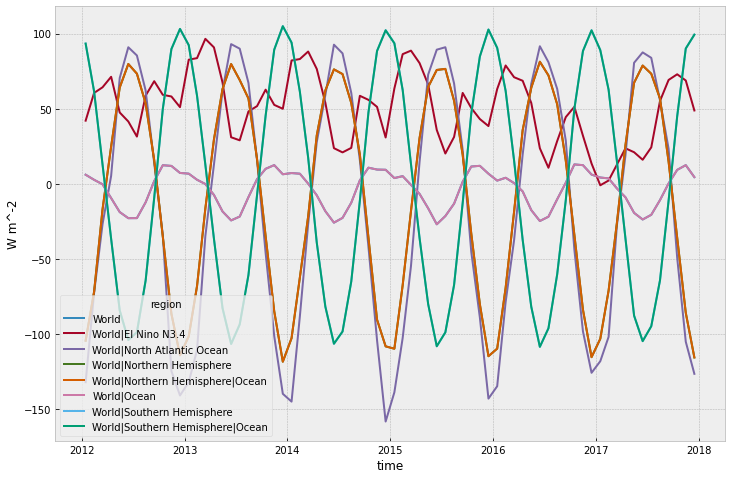

In [7]:
# NBVAL_IGNORE_OUTPUT
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
stitched.lineplot(hue="region", ax=ax)

The files are also written with extensive metadata, which we can access via the `MAGICCData` instance's `.metadata` attribute. The 'child' metadata is the metadata of the 'child' simulation (in this case 'ssp585') while the parent data is the data from the simulation the 'child' branched off (in this case 'historical').

In [8]:
# NBVAL_IGNORE_OUTPUT
stitched.metadata

{'timeseriestype': 'MONTHLY',
 'date': '2020-10-08 13:09:11',
 'contact': 'notebook example <email address>',
 '(child) CDI': 'Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/cdi)',
 '(child) CDO': 'Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/cdo)',
 '(child) Conventions': 'CF-1.7',
 '(child) area_world (m**2)': '510045092655104.0',
 '(child) area_world_el_nino_n3.4 (m**2)': '6657359020032.0',
 '(child) area_world_north_atlantic_ocean (m**2)': '55474658279424.0',
 '(child) area_world_northern_hemisphere (m**2)': '225108691435520.0',
 '(child) area_world_northern_hemisphere_ocean (m**2)': '225108691435520.0',
 '(child) area_world_ocean (m**2)': '510045092655104.0',
 '(child) area_world_southern_hemisphere (m**2)': '284936401219584.0',
 '(child) area_world_southern_hemisphere_ocean (m**2)': '284936401219584.0',
 '(child) branch_method': 'standard',
 '(child) branch_time_in_child': '60265.0',
 '(child) branch_time_in_parent': '60265.0',
 '(child) calendar': 'prol

## Stitching and normalising

On top of stitching, we might also normalise. This means we find the piControl run, and then normalise our output data against the piControl somehow. The available methods shown in the help of `--normalise` option of netcdf-scm stitch.

In [9]:
# NBVAL_IGNORE_OUTPUT
!netcdf-scm stitch --help | grep -2 normalise

                                  variables.

  --normalise [31-yr-mean-after-branch-time|21-yr-running-mean|21-yr-running-mean-dedrift|30-yr-running-mean|30-yr-running-mean-dedrift]
                                  How to normalise the data relative to
                                  piControl (if not provided, no normalisation
                                  is performed).


We can run the stitching for these five different options as shown below.

In [10]:
# NBVAL_IGNORE_OUTPUT
!netcdf-scm stitch \
    "../../../tests/test-data/expected-crunching-output/marble-cmip5" \
    "../../../output-examples/stitched-normalised-files-31-yr-mean-after-branch-time" \
    "notebook example <email address>" \
    --force \
    --drs "MarbleCMIP5" \
    --regexp ".*rcp45.*tas.*NorESM1.*" \
    --normalise "31-yr-mean-after-branch-time"

!netcdf-scm stitch \
    "../../../tests/test-data/expected-crunching-output/marble-cmip5" \
    "../../../output-examples/stitched-normalised-files-21-yr-running-mean" \
    "notebook example <email address>" \
    --force \
    --drs "MarbleCMIP5" \
    --regexp ".*rcp45.*tas.*NorESM1.*" \
    --normalise "21-yr-running-mean"

!netcdf-scm stitch \
    "../../../tests/test-data/expected-crunching-output/marble-cmip5" \
    "../../../output-examples/stitched-normalised-files-21-yr-running-mean-dedrift" \
    "notebook example <email address>" \
    --force \
    --drs "MarbleCMIP5" \
    --regexp ".*rcp45.*tas.*NorESM1.*" \
    --normalise "21-yr-running-mean-dedrift" 

!netcdf-scm stitch \
    "../../../tests/test-data/expected-crunching-output/marble-cmip5" \
    "../../../output-examples/stitched-normalised-files-30-yr-running-mean" \
    "notebook example <email address>" \
    --force \
    --drs "MarbleCMIP5" \
    --regexp ".*rcp45.*tas.*NorESM1.*" \
    --normalise "30-yr-running-mean" 

!netcdf-scm stitch \
    "../../../tests/test-data/expected-crunching-output/marble-cmip5" \
    "../../../output-examples/stitched-normalised-files-30-yr-running-mean-dedrift" \
    "notebook example <email address>" \
    --force \
    --drs "MarbleCMIP5" \
    --regexp ".*rcp45.*tas.*NorESM1.*" \
    --normalise "30-yr-running-mean-dedrift" 

23553 2020-10-08 13:09:19,549 INFO:netcdf_scm:netcdf-scm: 2.0.0rc5+9.gf0c1d5a.dirty
23553 2020-10-08 13:09:19,550 INFO:netcdf_scm:stitch-contact: notebook example <email address>
23553 2020-10-08 13:09:19,550 INFO:netcdf_scm:source: /Users/znicholls/Documents/AGCEC/netCDF-SCM/netcdf-scm/tests/test-data/expected-crunching-output/marble-cmip5
23553 2020-10-08 13:09:19,550 INFO:netcdf_scm:destination: /Users/znicholls/Documents/AGCEC/netCDF-SCM/netcdf-scm/output-examples/stitched-normalised-files-31-yr-mean-after-branch-time
23553 2020-10-08 13:09:19,550 INFO:netcdf_scm:regexp: .*rcp45.*tas.*NorESM1.*
23553 2020-10-08 13:09:19,550 INFO:netcdf_scm:prefix: None
23553 2020-10-08 13:09:19,550 INFO:netcdf_scm:out-format: mag-files
23553 2020-10-08 13:09:19,550 INFO:netcdf_scm:drs: MarbleCMIP5
23553 2020-10-08 13:09:19,550 INFO:netcdf_scm:force: True
23553 2020-10-08 13:09:19,550 INFO:netcdf_scm:number-workers: 4
23553 2020-10-08 13:09:19,550 INFO:netcdf_scm:target-units-specs: None
23553 2020-

100%|████████████████████████████████████████| 1.00/1.00 [00:22<00:00, 22.8s/it]


In [11]:
written_files = {
    norm_id: [
        f
        for f in Path(
            "../../../output-examples/stitched-normalised-files-{}/cmip5".format(
                norm_id
            )
        ).rglob("*.MAG")
    ]
    for norm_id in [
        "31-yr-mean-after-branch-time",
        "21-yr-running-mean",
        "21-yr-running-mean-dedrift",
        "30-yr-running-mean",
        "30-yr-running-mean-dedrift",
    ]
}
written_files

{'31-yr-mean-after-branch-time': [PosixPath('../../../output-examples/stitched-normalised-files-31-yr-mean-after-branch-time/cmip5/rcp45/Amon/tas/NorESM1-M/r1i1p1/netcdf-scm_tas_Amon_NorESM1-M_rcp45_r1i1p1_185001-230012.MAG')],
 '21-yr-running-mean': [PosixPath('../../../output-examples/stitched-normalised-files-21-yr-running-mean/cmip5/rcp45/Amon/tas/NorESM1-M/r1i1p1/netcdf-scm_tas_Amon_NorESM1-M_rcp45_r1i1p1_185001-230012.MAG')],
 '21-yr-running-mean-dedrift': [PosixPath('../../../output-examples/stitched-normalised-files-21-yr-running-mean-dedrift/cmip5/rcp45/Amon/tas/NorESM1-M/r1i1p1/netcdf-scm_tas_Amon_NorESM1-M_rcp45_r1i1p1_185001-230012.MAG')],
 '30-yr-running-mean': [PosixPath('../../../output-examples/stitched-normalised-files-30-yr-running-mean/cmip5/rcp45/Amon/tas/NorESM1-M/r1i1p1/netcdf-scm_tas_Amon_NorESM1-M_rcp45_r1i1p1_185001-230012.MAG')],
 '30-yr-running-mean-dedrift': [PosixPath('../../../output-examples/stitched-normalised-files-30-yr-running-mean-dedrift/cmip5/rcp45

In [12]:
# NBVAL_IGNORE_OUTPUT
stitched_normalised = []
for norm_id, files in written_files.items():
    assert len(files) == 1
    out = load_mag_file(str(files[0]), drs="MarbleCMIP5")
    out["normalisation_method"] = norm_id
    stitched_normalised.append(out)

stitched_normalised = run_append(stitched_normalised)
stitched_normalised.timeseries()

time                                                                                                                                         1850-01-15 12:00:00  \
activity_id climate_model member_id mip_era model       normalisation_method         region                          scenario unit variable                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified 31-yr-mean-after-branch-time World                           rcp45    K    tas                 -2.062360   
                                                                                     World|El Nino N3.4              rcp45    K    tas                 -0.318386   
                                                                                     World|Land                      rcp45    K    tas                 -6.029940   
                                                                                     World|North Atlantic Ocean      rcp45    K    tas                 -2.214140   
                                                                                     World|Northern Hemisphere       rcp45    K    tas                 -6.668830   
                                                                                     World|Northern Hemisphere|Land  rcp45    K    tas                -11.948100   
                                                                                     World|Northern Hemisphere|Ocean rcp45    K    tas                 -3.287520   
                                                                                     World|Ocean                     rcp45    K    tas                 -0.443796   
                                                                                     World|Southern Hemisphere       rcp45    K    tas                  2.544110   
                                                                                     World|Southern Hemisphere|Land  rcp45    K    tas                  6.191210   
                                                                                     World|Southern Hemisphere|Ocean rcp45    K    tas                  1.693800   
                                                        21-yr-running-mean           World                           rcp45    K    tas                 -1.931070   
                                                                                     World|El Nino N3.4              rcp45    K    tas                  0.163975   
                                                                                     World|Land                      rcp45    K    tas                 -5.911670   
                                                                                     World|North Atlantic Ocean      rcp45    K    tas                 -2.128510   
                                                                                     World|Northern Hemisphere       rcp45    K    tas                 -6.535340   
                                                                                     World|Northern Hemisphere|Land  rcp45    K    tas                -11.851800   
                                                                                     World|Northern Hemisphere|Ocean rcp45    K    tas                 -3.130190   
                                                                                     World|Ocean                     rcp45    K    tas                 -0.307189   
                                                                                     World|Southern Hemisphere       rcp45    K    tas                  2.673210   
                                                                                     World|Southern Hemisphere|Land  rcp45    K    tas                  6.354950   
                                                                                     World|Southern Hemisphere|Ocean rcp45    K    tas                  1.814830   
                                                        21-yr-ru

The normalisation using `*dedrift` only dedrifts the data so they have a different magnitude of values compared to the other normalisation methods.

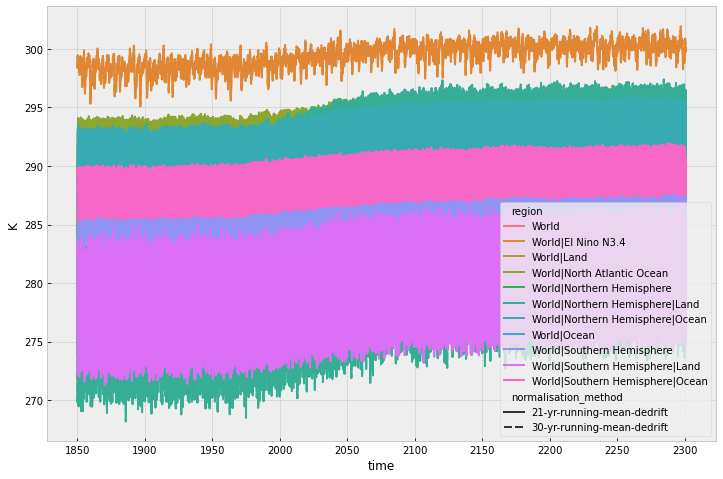

In [13]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
stitched_normalised.filter(normalisation_method="*dedrift").lineplot(
    hue="region", style="normalisation_method", ax=ax
);

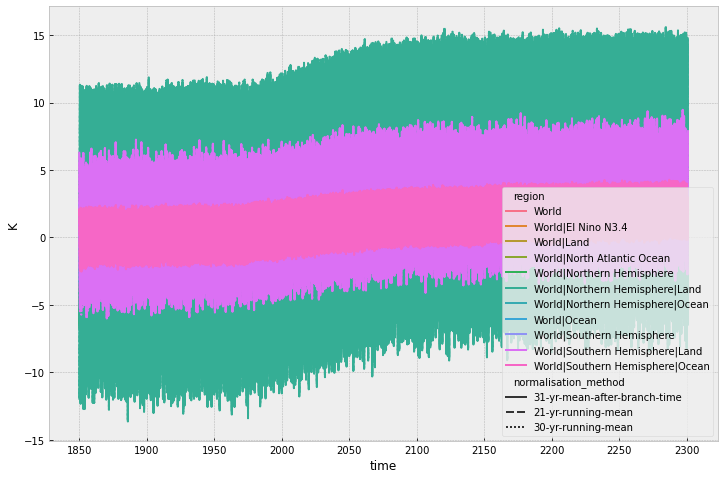

In [14]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
stitched_normalised_subset = stitched_normalised.filter(
    normalisation_method="*dedrift", keep=False
)
stitched_normalised_subset.lineplot(
    hue="region", style="normalisation_method", ax=ax
);

As we have monthly data, this doesn't tell us much yet. We can take an annual mean before plotting to see a clearer picture.

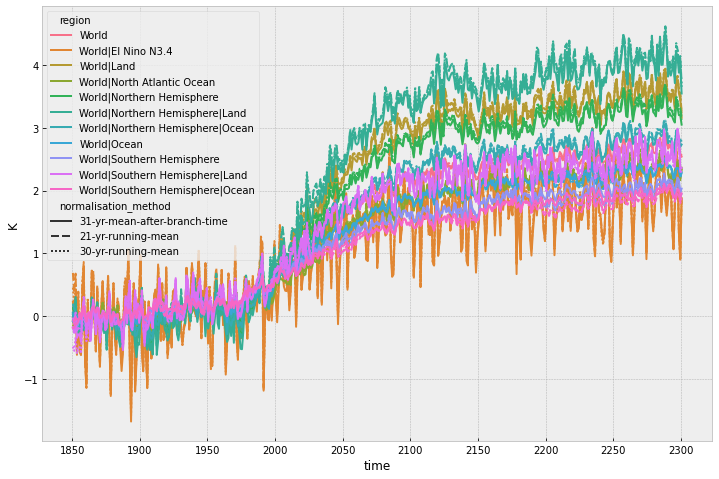

In [15]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
stitched_normalised_subset.time_mean("AC").lineplot(
    hue="region", style="normalisation_method", ax=ax
);

If we only plot world, we get a better sense of the importance of the normalisation method. In this case it makes little difference.

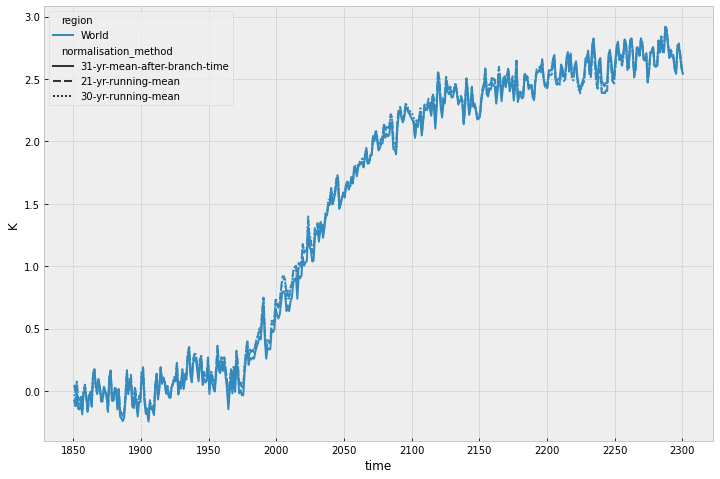

In [16]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
stitched_normalised_subset.time_mean("AC").filter(region="World").lineplot(
    hue="region", style="normalisation_method", ax=ax
);

With a bit of digging, we can get all the data used to make the above plot.

In [17]:
test_cmip5_crunch_output = os.path.join(
    "..",
    "..",
    "..",
    "tests",
    "test-data",
    "expected-crunching-output",
    "marble-cmip5",
    "cmip5",
)

In [18]:
# NBVAL_IGNORE_OUTPUT
helper = load_mag_file(
    str(written_files["31-yr-mean-after-branch-time"][0]), drs="MarbleCMIP5"
)


def get_path(generation):
    fp = os.path.join(
        test_cmip5_crunch_output,
        "*",
        helper.metadata["({}) netcdf-scm crunched file".format(generation)],
    )

    return glob.glob(fp)[0]


def load_generation(generation):
    return load_scmrun(get_path(generation))


child = load_generation("child")
parent = load_generation("parent")
normalisation = load_generation("normalisation")

normalisation.head()

time                                                                                                                                    0700-01-16 12:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario  unit variable variable_standard_name                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified World|Northern Hemisphere       piControl K    tas      air_temperature                  280.171925   
                                                        World|Southern Hemisphere       piControl K    tas      air_temperature                  288.463687   
                                                        World|Southern Hemisphere|Ocean piControl K    tas      air_temperature                  289.557645   
                                                        World|North Atlantic Ocean      piControl K    tas      air_temperature                  289.182025   
                                                        World                           piControl K    tas      air_temperature                  284.317806   

time                                                                                                                                    0700-02-15 00:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario  unit variable variable_standard_name                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified World|Northern Hemisphere       piControl K    tas      air_temperature                  281.224605   
                                                        World|Southern Hemisphere       piControl K    tas      air_temperature                  288.230767   
                                                        World|Southern Hemisphere|Ocean piControl K    tas      air_temperature                  289.777091   
                                                        World|North Atlantic Ocean      piControl K    tas      air_temperature                  289.093267   
                                                        World                           piControl K    tas      air_temperature                  284.727686   

time                                                                                                                                    0700-03-16 12:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario  unit variable variable_standard_name                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified World|Northern Hemisphere       piControl K    tas      air_temperature                  283.185317   
                                                        World|Southern Hemisphere       piControl K    tas      air_temperature                  287.332330   
                                                        World|Southern Hemisphere|Ocean piControl K    tas      air_temperature                  289.490769   
                                                        World|North Atlantic Ocean      piControl K    tas      air_temperature                  289.323014   
                                                        World                           piControl K    tas      air_temperature                  285.258824   

time                                                                                                                                    0700-04-16 00:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario  unit variable variable_standard_name                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified World|Northern Hemisphere       piControl K    tas      air_temperature                  286.255835   
                                                        World|Southern Hemisphere       piControl K    tas      air_temperature                  286.383418   
                      

We can then recover the branching time.

In [19]:
branching_time = get_branch_time(parent, parent_path=get_path("normalisation"))
branching_time

datetime.datetime(700, 1, 1, 0, 0)

We can then shift our normalisation such that the branch times line up.

In [20]:
# NBVAL_IGNORE_OUTPUT
normalisation_shifted = normalisation.timeseries()
normalisation_shifted.columns = normalisation_shifted.columns.map(
    lambda x: dt.datetime(
        x.year - branching_time.year + parent["time"].min().year,
        x.month,
        x.day,
        x.hour,
    )
)
normalisation_shifted = normalisation_shifted.reset_index()
normalisation_shifted["scenario"] = "piControl-shifted"
normalisation_shifted = ScmRun(normalisation_shifted)
normalisation_shifted.head()

time                                                                                                                                            1850-01-16 12:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario          unit variable variable_standard_name                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified World|Northern Hemisphere       piControl-shifted K    tas      air_temperature                  280.171925   
                                                        World|Southern Hemisphere       piControl-shifted K    tas      air_temperature                  288.463687   
                                                        World|Southern Hemisphere|Ocean piControl-shifted K    tas      air_temperature                  289.557645   
                                                        World|North Atlantic Ocean      piControl-shifted K    tas      air_temperature                  289.182025   
                                                        World                           piControl-shifted K    tas      air_temperature                  284.317806   

time                                                                                                                                            1850-02-15 00:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario          unit variable variable_standard_name                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified World|Northern Hemisphere       piControl-shifted K    tas      air_temperature                  281.224605   
                                                        World|Southern Hemisphere       piControl-shifted K    tas      air_temperature                  288.230767   
                                                        World|Southern Hemisphere|Ocean piControl-shifted K    tas      air_temperature                  289.777091   
                                                        World|North Atlantic Ocean      piControl-shifted K    tas      air_temperature                  289.093267   
                                                        World                           piControl-shifted K    tas      air_temperature                  284.727686   

time                                                                                                                                            1850-03-16 12:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario          unit variable variable_standard_name                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified World|Northern Hemisphere       piControl-shifted K    tas      air_temperature                  283.185317   
                                                        World|Southern Hemisphere       piControl-shifted K    tas      air_temperature                  287.332330   
                                                        World|Southern Hemisphere|Ocean piControl-shifted K    tas      air_temperature                  289.490769   
                                                        World|North Atlantic Ocean      piControl-shifted K    tas      air_temperature                  289.323014   
                                                        World                           piControl-shifted K    tas      air_temperature                  285.258824   

time                                                                                                                                            1850-04-16 00:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario          unit variable variable_standard_name                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified World|Northern Hemisphere       piControl-shifted K    tas      air_temperature                  286

In [21]:
# NBVAL_IGNORE_OUTPUT
source_data = run_append([child, parent, normalisation, normalisation_shifted])
source_data.head()

time                                                                                                                                   0700-01-16 12:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario unit variable variable_standard_name                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified World|Northern Hemisphere       rcp45    K    tas      air_temperature                         NaN   
                                                        World|Southern Hemisphere       rcp45    K    tas      air_temperature                         NaN   
                                                        World|Southern Hemisphere|Ocean rcp45    K    tas      air_temperature                         NaN   
                                                        World|North Atlantic Ocean      rcp45    K    tas      air_temperature                         NaN   
                                                        World                           rcp45    K    tas      air_temperature                         NaN   

time                                                                                                                                   0700-02-15 00:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario unit variable variable_standard_name                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified World|Northern Hemisphere       rcp45    K    tas      air_temperature                         NaN   
                                                        World|Southern Hemisphere       rcp45    K    tas      air_temperature                         NaN   
                                                        World|Southern Hemisphere|Ocean rcp45    K    tas      air_temperature                         NaN   
                                                        World|North Atlantic Ocean      rcp45    K    tas      air_temperature                         NaN   
                                                        World                           rcp45    K    tas      air_temperature                         NaN   

time                                                                                                                                   0700-03-16 12:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario unit variable variable_standard_name                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified World|Northern Hemisphere       rcp45    K    tas      air_temperature                         NaN   
                                                        World|Southern Hemisphere       rcp45    K    tas      air_temperature                         NaN   
                                                        World|Southern Hemisphere|Ocean rcp45    K    tas      air_temperature                         NaN   
                                                        World|North Atlantic Ocean      rcp45    K    tas      air_temperature                         NaN   
                                                        World                           rcp45    K    tas      air_temperature                         NaN   

time                                                                                                                                   0700-04-16 00:00:00  \
activity_id climate_model member_id mip_era model       region                          scenario unit variable variable_standard_name                        
cmip5       NorESM1-M     r1i1p1    CMIP5   unspecified World|Northern Hemisphere       rcp45    K    tas      air_temperature                         NaN   
                                                        World|Southern Hemisphere       rcp45    K    tas      air_temperature                         NaN   
                                               

The next cell makes a plot which shows how the 31 year mean after branching time method works.

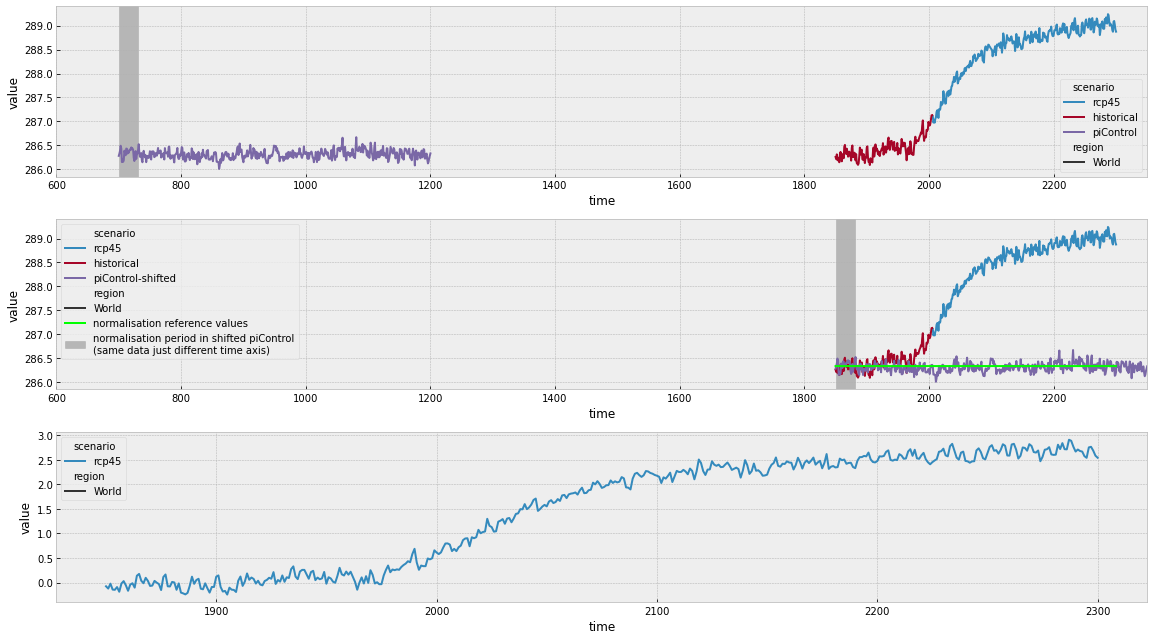

In [22]:
region_to_plot = "World"
norm_method = "31-yr-mean-after-branch-time"
full_view_xlim = [600, 2350]

fig = plt.figure(figsize=(16, 9))


def get_plot_df(src_data):
    out = src_data.time_mean("AC").long_data()
    out["time"] = out["time"].apply(lambda x: x.year)

    return out


ax = fig.add_subplot(311)
sns_df = get_plot_df(
    source_data.filter(scenario="*shifted", keep=False).filter(
        region=region_to_plot,
    )
)
sns.lineplot(
    data=sns_df, x="time", y="value", hue="scenario", style="region", ax=ax
)
ax.axvspan(
    branching_time.year,
    branching_time.year + 31,
    label="normalisation period in raw piControl",
    alpha=0.5,
    color="gray",
)
ax.set_xlim(full_view_xlim)

ax = fig.add_subplot(312)
sns_df = get_plot_df(
    source_data.filter(scenario="piControl", keep=False).filter(
        region=region_to_plot,
    )
)
ax = sns.lineplot(
    data=sns_df, x="time", y="value", hue="scenario", style="region", ax=ax
)

tmp = stitched_normalised.filter(
    region=region_to_plot,
    year=range(1700, 2351),
    normalisation_method=norm_method,
).timeseries()
tmp.index = normalisation.filter(region=region_to_plot).timeseries().index

normaliser = get_normaliser(norm_method)
reference_values = normaliser.get_reference_values(
    pymagicc.io.MAGICCData(tmp),
    normalisation.filter(region=region_to_plot),
    branching_time,
)
ax.plot(
    reference_values.columns.map(lambda x: x.year).values.squeeze(),
    reference_values.values.squeeze(),
    label="normalisation reference values",
    color="lime",
)


ax.axvspan(
    parent["time"].min().year,
    parent["time"].min().year + 31,
    label="normalisation period in shifted piControl\n(same data just different time axis)",
    alpha=0.5,
    color="gray",
)
ax.set_xlim(full_view_xlim)
ax.legend()

ax = fig.add_subplot(313)
sns_df = get_plot_df(
    stitched_normalised.filter(
        region=region_to_plot,
        year=range(1700, 2351),
        normalisation_method=norm_method,
    )
)
sns.lineplot(
    data=sns_df, x="time", y="value", hue="scenario", style="region", ax=ax
)

plt.tight_layout();

In the top panel above, we can see how the historical and rcp45 simulations have been joined. We can also see the normalisation period that is used. In the middle panel we can see how these compare when the time axes are shifted as well as the values which are used to normalise the simulations. In the bottom panel, we can see the resulting stitched and normalised timeseries.

Next we produce a similar plot for the 21-year (or 30-year) running mean method.

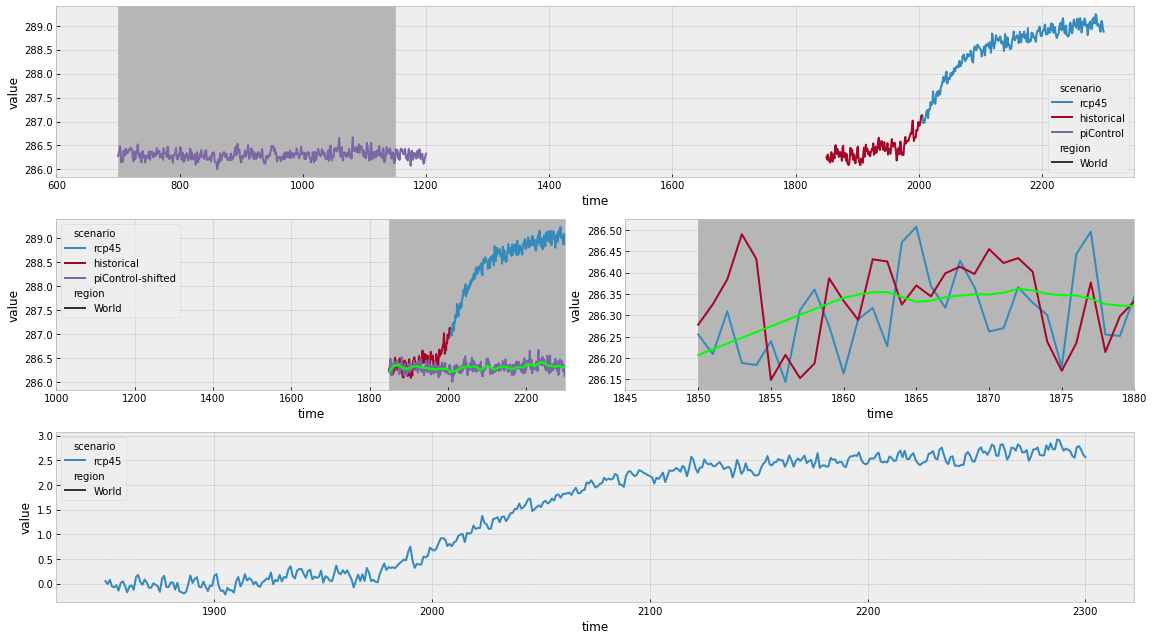

In [23]:
region_to_plot = "World"
norm_method = "21-yr-running-mean"
# norm_method = "30-yr-running-mean"
full_view_xlim = [600, 2350]

fig = plt.figure(figsize=(16, 9))


def get_plot_df(src_data):
    out = src_data.time_mean("AC").long_data()
    out["time"] = out["time"].apply(lambda x: x.year)

    return out


ax = fig.add_subplot(311)
sns_df = get_plot_df(
    source_data.filter(scenario="*shifted", keep=False).filter(
        region=region_to_plot,
    )
)
sns.lineplot(
    data=sns_df, x="time", y="value", hue="scenario", style="region", ax=ax
)
ax.axvspan(
    branching_time.year,
    branching_time.year + child["time"].max().year - parent["time"].min().year,
    label="normalisation period in raw piControl",
    alpha=0.5,
    color="gray",
)
ax.set_xlim(full_view_xlim)

for i, (no, xlim) in enumerate(zip((323, 324), ([1000, 2300], [1845, 1880]))):
    ax = fig.add_subplot(no)
    sns_df = get_plot_df(
        source_data.filter(scenario="piControl", keep=False).filter(
            region=region_to_plot, year=range(xlim[0], xlim[1] + 1)
        )
    )
    ax = sns.lineplot(
        data=sns_df, x="time", y="value", hue="scenario", style="region", ax=ax
    )

    tmp = stitched_normalised.filter(
        region=region_to_plot,
        year=range(xlim[0], xlim[1] + 1),
        normalisation_method=norm_method,
    ).timeseries()
    tmp.index = normalisation.filter(region=region_to_plot).timeseries().index

    normaliser = get_normaliser(norm_method)
    reference_values = get_plot_df(
        ScmRun(
            normaliser.get_reference_values(
                pymagicc.io.MAGICCData(tmp),
                normalisation.filter(region=region_to_plot),
                branching_time,
            )
        )
    )
    ax.plot(
        reference_values["time"],
        reference_values["value"],
        label="normalisation reference values",
        color="lime",
    )

    ax.axvspan(
        parent["time"].min().year,
        child["time"].max().year,
        label="normalisation period in shifted piControl\n(same data just different time axis)",
        alpha=0.5,
        color="gray",
    )

    if i == 1:
        ax.get_legend().remove()

    ax.set_xlim(xlim)

ax = fig.add_subplot(313)
sns_df = get_plot_df(
    stitched_normalised.filter(
        region=region_to_plot,
        year=range(1700, 2351),
        normalisation_method=norm_method,
    )
)
sns.lineplot(
    data=sns_df, x="time", y="value", hue="scenario", style="region", ax=ax
)

plt.tight_layout();

Once again, in the top panel above, we can see how the historical and rcp45 simulations have been joined and the normalisation period that is used. In this case, we use a much longer slice of the piControl run because we need a 21-year running mean over the period corresponding to the scenario runs. 

In the middle panels we can see how these compare when the time axes are shifted as well as the values which are used to normalise the simulations (this time with wiggles because it's a 21-year running mean). The right-hand middle panel illustrates our edge handling. A 21-year running mean can only be taken if there are 21 years around the time point of interest. However, it is often the case that the piControl data starts in the same year as the experiment data. In such a case, to fill in the first 10 years (where a 21 year window is not available), we simply linearly extrapolate the running mean. It would be possible to make other choices, e.g. assuming a constant value or fitting some other curve. However, given how short the time period that must be filled is and how linear CMIP drifts are, other choices will make little difference.

In the bottom panel, we can see the resulting stitched and normalised timeseries.

## Plotting function

As a last step, we demonstrate a function which will make plots like the above for a given file. This could be run on lots of files to examine how the normalisation works in batches.

In [24]:
def plot_normalisation(
    inpath,
    netcdf_scm_crunched_root_dir,
    region_to_plot,
    axes,
    norm_colour="tab:green",
    dashes=[(10, 5)],
    legend=True,
    drs="MarbleCMIP5",
):
    mag_data = load_mag_file(str(inpath), drs=drs)

    return plot_normalisation_scmdf(
        mag_data.filter(region=region_to_plot),
        netcdf_scm_crunched_root_dir,
        region_to_plot,
        axes,
        norm_colour=norm_colour,
        dashes=dashes,
        legend=legend,
    )


def get_highest_valid_level_and_source_files(
    scmdata, netcdf_scm_crunched_root_dir
):
    source_files = {
        "normalisation": os.path.join(
            netcdf_scm_crunched_root_dir,
            scmdata.metadata["(normalisation) netcdf-scm crunched file"],
        )
    }

    level = "child"
    for i in range(20):
        level_key = "({})".format(level)
        try:
            source_files[level] = os.path.join(
                netcdf_scm_crunched_root_dir,
                scmdata.metadata[
                    "{} netcdf-scm crunched file".format(level_key)
                ],
            )
        except KeyError:
            break

        highest_valid_level = level
        level = (
            step_up_family_tree(level_key).replace("(", "").replace(")", "")
        )
    else:
        raise ValueError("level = {}, really?".format(level))

    return highest_valid_level, source_files


def get_shifted_normalisation(
    normalisation, branching_time, highest_level_start
):
    normalisation_shifted = normalisation.timeseries()

    normalisation_shifted.columns = normalisation_shifted.columns.map(
        lambda x: dt.datetime(
            x.year - branching_time.year + highest_level_start.year,
            x.month,
            x.day,
            x.hour,
        )
    )
    normalisation_shifted = normalisation_shifted.reset_index()
    normalisation_shifted["scenario"] = "{}-shifted".format(
        normalisation.get_unique_meta("scenario", no_duplicates=True)
    )
    normalisation_shifted = ScmRun(normalisation_shifted)

    return normalisation_shifted


def get_plot_df(src_data):
    out = src_data.time_mean("AC").long_data()
    out["time"] = out["time"].apply(lambda x: x.year)

    return out


def make_plot(
    axes,
    source_data,
    source_scmdfs,
    stitched_normalised,
    region_to_plot,
    branching_time,
    highest_level,
    highest_level_start,
    norm_colour,
    dashes,
    legend,
):
    sns_df = get_plot_df(
        source_data.filter(scenario="*shifted", keep=False).filter(
            region=region_to_plot,
        )
    )
    axes[0] = sns.lineplot(
        data=sns_df,
        x="time",
        y="value",
        hue="scenario",
        style="region",
        ax=axes[0],
        dashes=dashes,
        legend=legend if not legend else "brief",
    )
    axes[0].axvline(
        branching_time.year,
        label="branch point in raw piControl",
        alpha=0.5,
        color="gray",
    )
    if legend:
        axes[0].legend()

    axes[0].set_title("Raw data")

    sns_df = get_plot_df(
        source_data.filter(
            scenario=source_scmdfs["normalisation"].get_unique_meta(
                "scenario", no_duplicates=True
            ),
            keep=False,
        ).filter(region=region_to_plot,)
    )

    existing_handles, existing_labels = axes[1].get_legend_handles_labels()

    axes[1] = sns.lineplot(
        data=sns_df,
        x="time",
        y="value",
        hue="scenario",
        style="region",
        ax=axes[1],
        dashes=dashes,
        legend=legend if not legend else "brief",
    )

    tmp = stitched_normalised.filter(region=region_to_plot,).timeseries()
    tmp.index = (
        source_scmdfs["normalisation"]
        .filter(region=region_to_plot)
        .timeseries()
        .index
    )

    normaliser = get_normaliser(
        stitched_normalised.metadata["normalisation method"]
    )
    reference_values = normaliser.get_reference_values(
        pymagicc.io.MAGICCData(tmp),
        source_scmdfs["normalisation"].filter(region=region_to_plot),
        branching_time,
    )
    norm_label = "normalisation reference values"
    norm_handle = axes[1].plot(
        reference_values.columns.map(lambda x: x.year).values.squeeze(),
        reference_values.values.squeeze(),
        label=norm_label,
        color=norm_colour,
        dashes=dashes[0],
    )
    axes[1].set_title("Shifted normalisation data")

    axes[1].axvline(
        highest_level_start.year,
        label="branch point in shifted piControl\n(same data just different time axis)",
        alpha=0.5,
        color="gray",
    )
    axes[1].set_xlim(
        source_scmdfs[highest_level]["year"].min() - 100,
        source_scmdfs["child"]["year"].max() + 200,
    )

    if legend:
        axes[1].legend(loc="right")
    else:
        handles = existing_handles + [norm_handle]
        labels = existing_labels + [norm_label]
        axes[1].legend(handles, labels, loc="right")

    sns_df = get_plot_df(stitched_normalised.filter(region=region_to_plot,))
    axes[2] = sns.lineplot(
        data=sns_df,
        x="time",
        y="value",
        hue="scenario",
        style="region",
        ax=axes[2],
        dashes=dashes,
        legend=legend if not legend else "brief",
    )
    axes[2].set_title("Stiched and normalised data")

    return axes


def plot_normalisation_scmdf(
    scmdf_in,
    netcdf_scm_crunched_root_dir,
    region_to_plot,
    axes,
    norm_colour="tab:green",
    dashes=[(10, 5)],
    legend=True,
):
    scmdf = scmdf_in.filter(region_to_plot)
    assert len(axes) == 3, "Must pass in three axes to plot on"

    (
        highest_valid_level,
        source_files,
    ) = get_highest_valid_level_and_source_files(
        scmdf, netcdf_scm_crunched_root_dir
    )

    source_scmdfs = {
        k: load_scmrun(v) for k, v in tqdm.tqdm(source_files.items())
    }

    highest_level_start = source_scmdfs[highest_valid_level]["time"].min()

    branching_time = get_branch_time(
        source_scmdfs[highest_valid_level],
        parent_path=source_files["normalisation"],
    )

    source_scmdfs["normalisation_shifted"] = get_shifted_normalisation(
        source_scmdfs["normalisation"], branching_time, highest_level_start,
    )

    source_data = run_append([v for v in source_scmdfs.values()])

    return make_plot(
        axes,
        source_data,
        source_scmdfs,
        scmdf_in,
        region_to_plot,
        branching_time,
        highest_valid_level,
        highest_level_start,
        norm_colour,
        dashes,
        legend,
    )

In [25]:
# NBVAL_IGNORE_OUTPUT
netcdf_scm_crunched_root_dir = os.path.join(
    "..",
    "..",
    "..",
    "tests",
    "test-data",
    "expected-crunching-output",
    "marble-cmip5",
    "cmip5",
    "Amon",
)

  0%|          | 0/3 [00:00<?, ?it/s]

31-yr-mean-after-branch-time


  0%|          | 0/3 [00:00<?, ?it/s]

21-yr-running-mean


100%|██████████| 3/3 [00:18<00:00,  6.05s/it]
<ipython-input-24-57a3f71751a0>:189: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x16094b610>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  axes[1].legend(handles, labels, loc="right")
  0%|          | 0/3 [00:00<?, ?it/s]

30-yr-running-mean


100%|██████████| 3/3 [00:17<00:00,  5.90s/it]
<ipython-input-24-57a3f71751a0>:189: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x162bfc6a0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  axes[1].legend(handles, labels, loc="right")


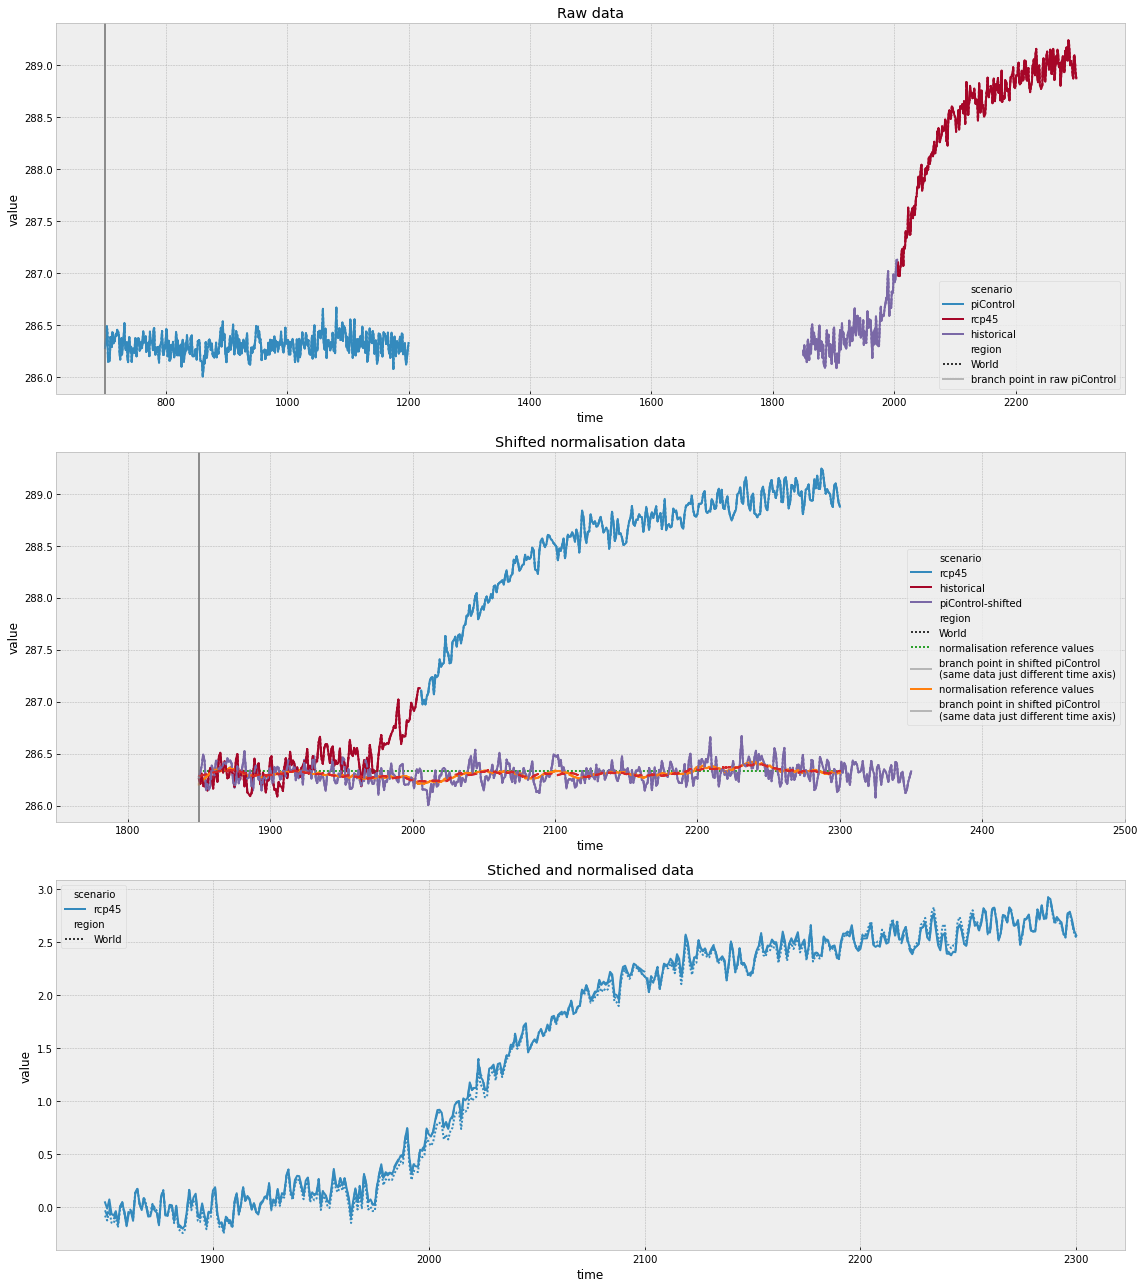

In [26]:
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 18))
axes = axes.flatten()

cfgs = {
    "31-yr-mean-after-branch-time": ("tab:green", [(1, 1)]),
    "21-yr-running-mean": ("tab:orange", [(None, None)]),
    "30-yr-running-mean": ("tab:red", [(5, 3)]),
}
for i, (n, f) in enumerate(written_files.items()):
    if n not in cfgs:
        continue

    print(n)
    colour, dashes = cfgs[n]
    plot_normalisation(
        f[0],
        netcdf_scm_crunched_root_dir,
        "World",
        axes,
        norm_colour=colour,
        dashes=dashes,
        legend=True if i == 0 else False,
    )

plt.tight_layout()

Note that below the normalisation values are intended for drifting, hence are zero, a very different magnitude to the ~287K of the raw data. This is why the middle plot is not exactly illuminating.

  0%|          | 0/3 [00:00<?, ?it/s]

21-yr-running-mean-dedrift


100%|██████████| 3/3 [00:17<00:00,  5.93s/it]
<ipython-input-24-57a3f71751a0>:189: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x16091b940>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  axes[1].legend(handles, labels, loc="right")
  0%|          | 0/3 [00:00<?, ?it/s]

30-yr-running-mean-dedrift


100%|██████████| 3/3 [00:16<00:00,  5.66s/it]
<ipython-input-24-57a3f71751a0>:189: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x162be9610>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  axes[1].legend(handles, labels, loc="right")


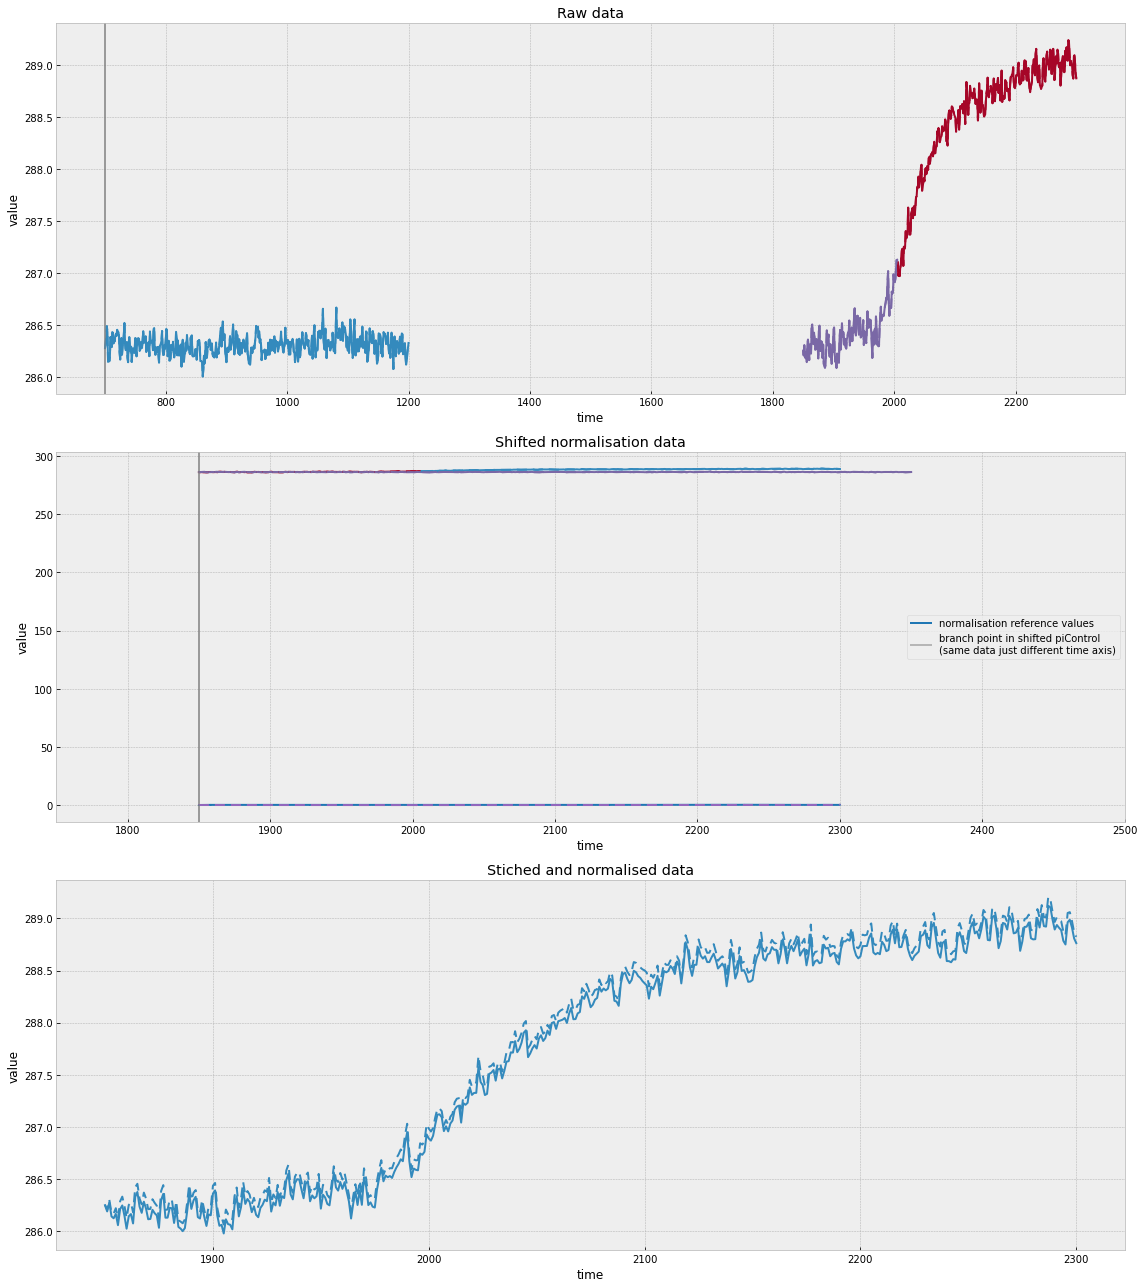

In [27]:
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 18))
axes = axes.flatten()

cfgs = {
    "21-yr-running-mean-dedrift": ("tab:blue", [(None, None)]),
    "30-yr-running-mean-dedrift": ("tab:purple", [(5, 3)]),
}
for i, (n, f) in enumerate(written_files.items()):
    if n not in cfgs:
        continue

    print(n)
    colour, dashes = cfgs[n]
    plot_normalisation(
        f[0],
        netcdf_scm_crunched_root_dir,
        "World",
        axes,
        norm_colour=colour,
        dashes=dashes,
        legend=True if i == 0 else False,
    )

plt.tight_layout()